In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
map = gpd.read_file('../data/AgrImOnIa/raw/AreasGeometriesWithNames.shp')
map = map.to_crs({'init': 'epsg:4326'})
map.head()

# Dimensions of the map
print(map.shape)

(427, 3)


C:\Users\camil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [14]:
model_file_name = "../output/2017_low_season_model_30wind_10m_0.csv"
model_data = gpd.read_file(model_file_name)

model_data.head()
model_data.shape

(427, 30)

In [15]:
geometry_cols = map[["MUNICIPALI", "geometry"]]
merged_df = pd.merge(model_data, geometry_cols, left_on="Municipality_Name", right_on="MUNICIPALI", how="inner")
merged_df.drop(["MUNICIPALI", "geometry_x"], axis=1, inplace=True)
merged_df.rename(columns={"geometry_y": "geometry"}, inplace=True)

# shift back the predictions by the initial value
mean_shift = pd.to_numeric(merged_df["PM25_original"], errors="coerce").mean()
merged_df["PM25_predictions"] = pd.to_numeric(merged_df["PM25_predictions"], errors="coerce") + mean_shift

merged_df.head()
merged_df.shape

(427, 30)

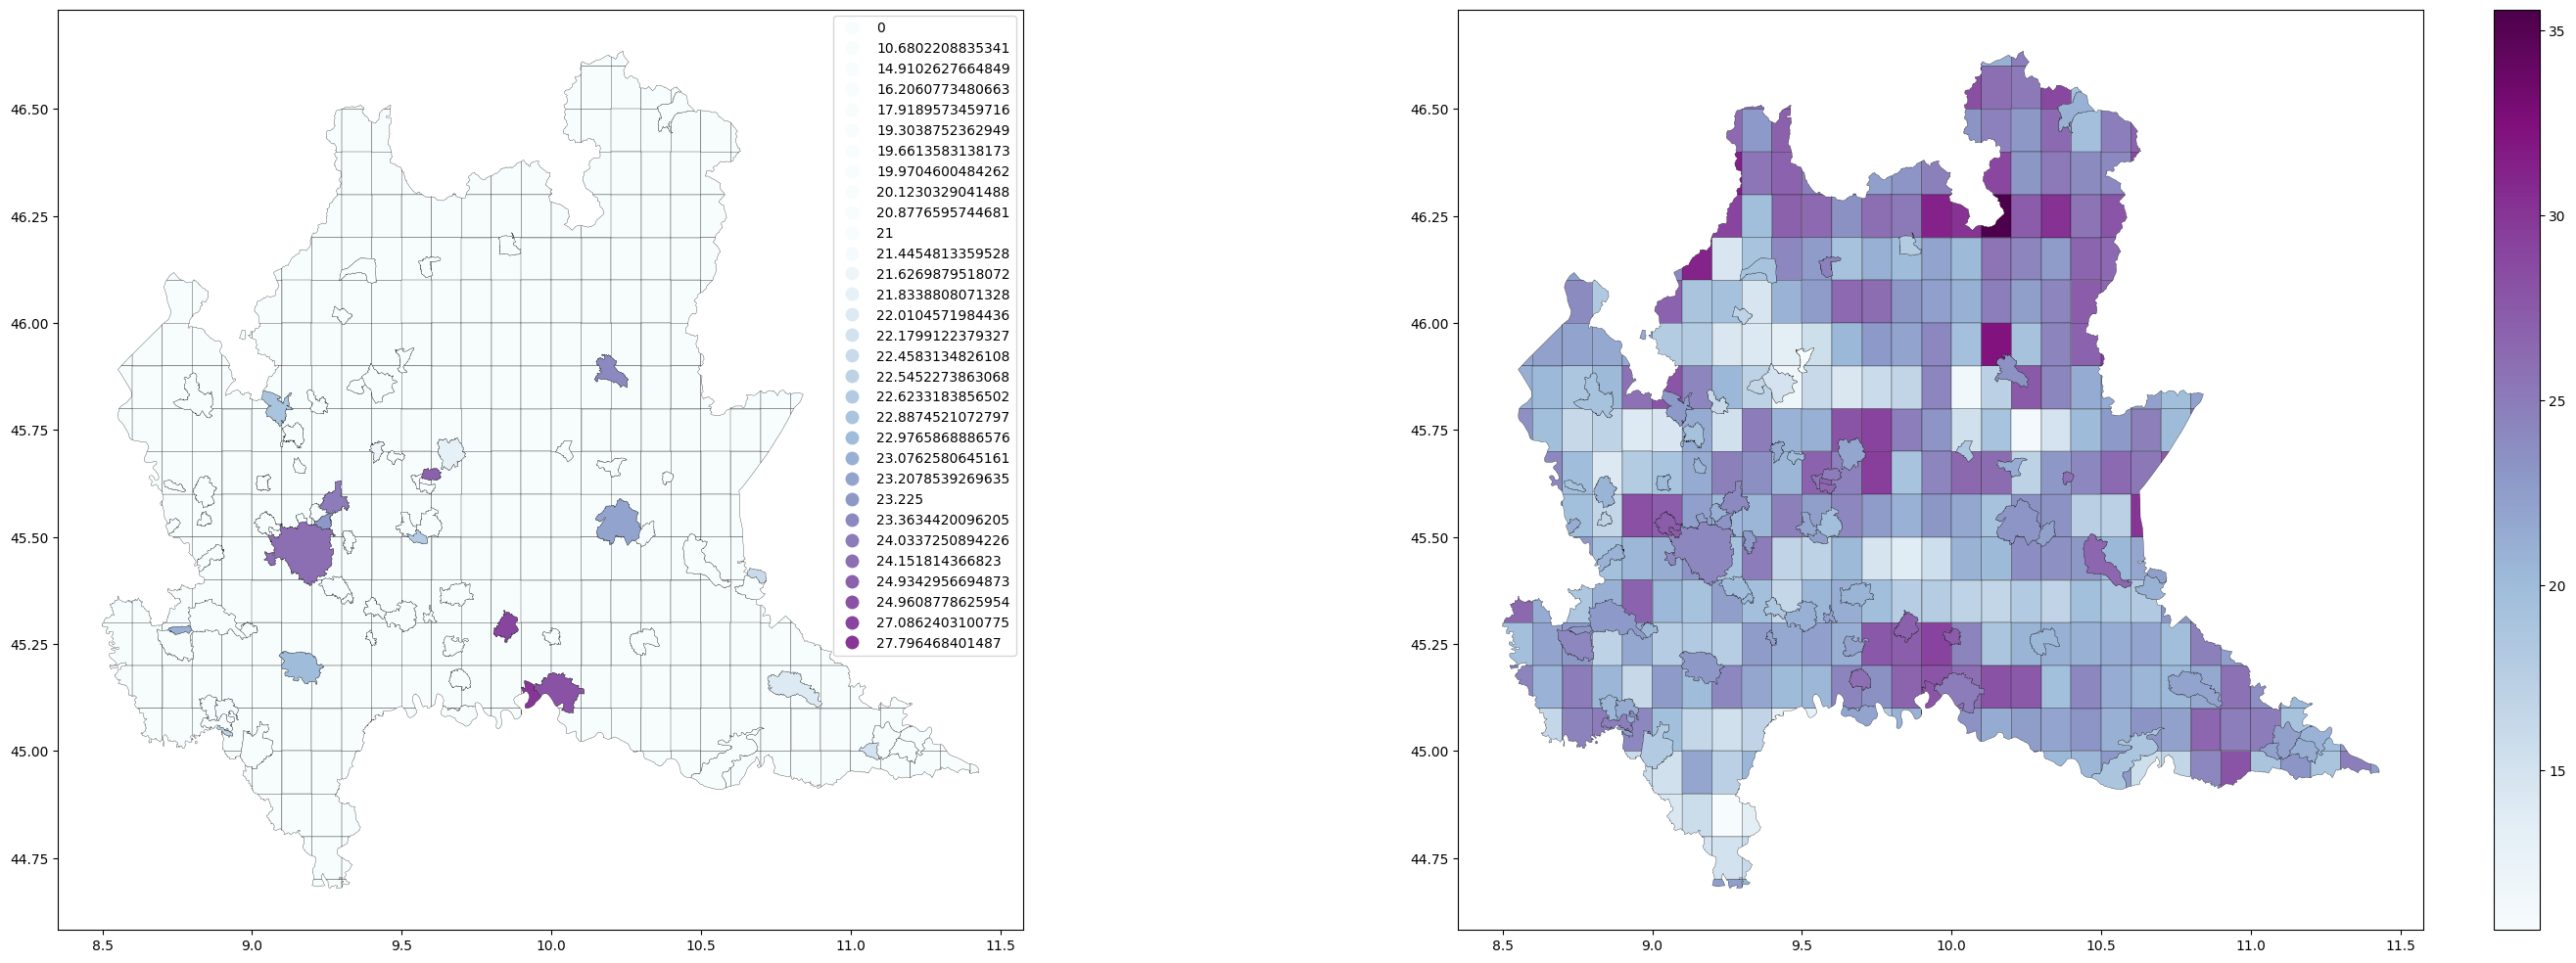

In [16]:
merged_df = merged_df.to_crs(map.crs)
cleaned_df = merged_df
cleaned_df["PM25_original"].replace("NA", 0, inplace=True)
# merged_df.plot(column="PM25_predictions", legend=True, cmap="BuPu")

min_value = min(merged_df["PM25_predictions"])
max_value = max(merged_df["PM25_predictions"])

fig, axs = plt.subplots(1, 2, figsize=(30, 10))

plt.tight_layout()
plot_values = ["PM25_original", "PM25_predictions"]
for i, ax in enumerate(axs): 
    cleaned_df.plot(
        ax=ax, 
        column=plot_values[i], 
        legend=True, 
        cmap="BuPu", 
        edgecolor='black', 
        linewidth=0.2,
        vmin=min_value,
        vmax=max_value
    )

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25],
 [Text(0, 0, 'LA_land_use'),
  Text(1, 0, 'EM_nox_sum'),
  Text(2, 0, 'WE_blh_layer_max'),
  Text(3, 0, 'LI_pigs'),
  Text(4, 0, 'EM_nh3_agr_soils'),
  Text(5, 0, 'LA_lvi'),
  Text(6, 0, 'WE_rh_min'),
  Text(7, 0, 'WE_wind_speed_100m_mean'),
  Text(8, 0, 'EM_nh3_livestock_mm'),
  Text(9, 0, 'EM_nh3_agr_waste_burn'),
  Text(10, 0, 'WE_temp_2m'),
  Text(11, 0, 'WE_wind_speed_10m_max'),
  Text(12, 0, 'WE_blh_layer_min'),
  Text(13, 0, 'WE_wind_speed_100m_max'),
  Text(14, 0, 'WE_wind_speed_10m_mean'),
  Text(15, 0, 'EM_nh3_sum'),
  Text(16, 0, 'Altitude'),
  Text(17, 0, 'WE_surface_pressure'),
  Text(18, 0, 'WE_rh_max'),
  Text(19, 0, 'WE_rh_mean'),
  Text(20, 0, 'WE_tot_precipitation'),
  Text(21, 0, 'LA_hvi'),
  Text(22, 0, 'WE_solar_radiation'),
  Text(23, 0, 'EM_so2_sum'),
  Text(24, 0, 'EM_nox_traffic'),
  Text(25, 0, 'LI_bovine')])

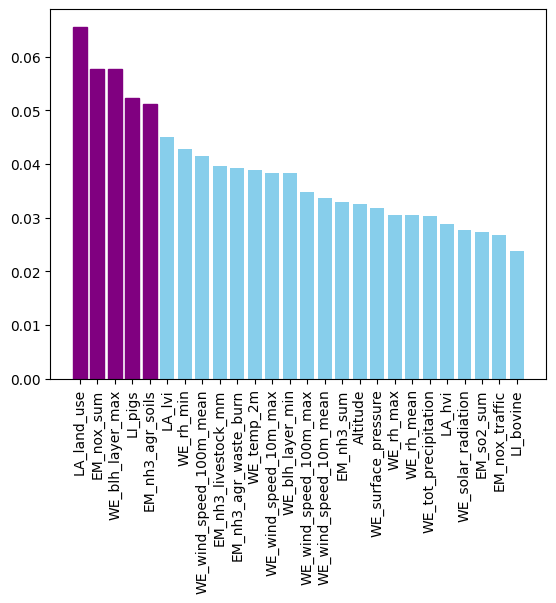

In [17]:
covariates_sel_file_name = "../output/2017_low_season_model_30wind_10m_0_cov_inclusion.csv"
covariates_selection = pd.read_csv(covariates_sel_file_name)

burnin = 5000
covariates_selection = covariates_selection.iloc[burnin:]
inclusion_probabilities = covariates_selection.sum(axis=0)
inclusion_probabilities = inclusion_probabilities / sum(inclusion_probabilities)

inclusion_probabilities = pd.DataFrame(inclusion_probabilities.sort_values(ascending=False))
inclusion_probabilities.columns = ["Inclusion_probability"]

bars = plt.bar(inclusion_probabilities.index, inclusion_probabilities["Inclusion_probability"], color="skyblue")

# highlight highest inclusion probabilities
for i, bar in enumerate(bars):
    if i < 5: 
        bar.set_color('purple')
        
plt.xticks(rotation=90)